# IMDB Sentiment analysis

# Due to laptops RAM running very slow so I have choosen randon 3000 rows to demo concept

### Importing required headers

In [1]:
import pandas as pd
import os
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import xml
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.stem import WordNetLemmatizer
import copy
from random import sample


%matplotlib inline

vectorizer = TfidfVectorizer(min_df=4)#, max_features = 1000)
TAG_RE = re.compile("(<[^>]+>)|(\.)|(\;)|(\:)|(\!)|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(\d+)|(<br\s*/><br\s*/>)|(\-)|(\/)")

Below lines are used to merge all files and create a single dataset
----------------
### Below line of code was used to create dataset from flat files downloaded 
###  Below lines are commented since dataset once created need not be created again

In [2]:
'''
data=[]
main_path= os.path.join('C:/digital vidya/Class room notes/datasets', 'aclImdb')
for head in os.listdir(main_path):
    print(head)
    if os.path.isdir(os.path.join(main_path,head)):
        label_path= os.path.join(main_path,head)
        print(label_path)
        for label in os.listdir(label_path):
            if os.path.isdir(os.path.join(label_path, label)):
                path = os.path.join(label_path,label)
                #print(path)
                files = [f for f in os.listdir(path) if f.endswith('.txt')]
                for fle in files:
                    with open(os.path.join(path,fle),encoding = 'latin-1') as f:
                        text = f.read()
                        #print(head, " ", label," ", fle)
                        data.append([head,text,label,fle])

df_master = pd.DataFrame(data,columns=['Type','Review','Label','File'])
'''

'\ndata=[]\nmain_path= os.path.join(\'C:/digital vidya/Class room notes/datasets\', \'aclImdb\')\nfor head in os.listdir(main_path):\n    print(head)\n    if os.path.isdir(os.path.join(main_path,head)):\n        label_path= os.path.join(main_path,head)\n        print(label_path)\n        for label in os.listdir(label_path):\n            if os.path.isdir(os.path.join(label_path, label)):\n                path = os.path.join(label_path,label)\n                #print(path)\n                files = [f for f in os.listdir(path) if f.endswith(\'.txt\')]\n                for fle in files:\n                    with open(os.path.join(path,fle),encoding = \'latin-1\') as f:\n                        text = f.read()\n                        #print(head, " ", label," ", fle)\n                        data.append([head,text,label,fle])\n\ndf_master = pd.DataFrame(data,columns=[\'Type\',\'Review\',\'Label\',\'File\'])\n'

In [3]:
#df_master.shape

In [4]:
#df_master.to_csv('C:/digital vidya/Class room notes/datasets/imdb_review.csv')

In [5]:
imdb_review = pd.read_csv('imdb_review.csv',index_col=0)
imdb_review.head()

,Type,Review,Label,File
0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [6]:
imdb_test = imdb_review[imdb_review['Type']=="test"]
imdb_test.shape

(25000, 4)

In [7]:
imdb_train= imdb_review[imdb_review['Type']=="train"]
imdb_train.shape  

(75000, 4)

In [8]:
print(imdb_test.Label.unique())
print(imdb_train.Label.unique())

['neg' 'pos']
['neg' 'pos' 'unsup']


## Seprating unsupervised data from train data 

In [9]:
imdb_train_unsup = imdb_train[imdb_train['Label']=="unsup"]
print(imdb_train_unsup.shape)
imdb_train_unsup.head()

(50000, 4)


,Type,Review,Label,File
50000,train,"I admit, the great majority of films released ...",unsup,0_0.txt
50001,train,"Take a low budget, inexperienced actors doubli...",unsup,10000_0.txt
50002,train,"Everybody has seen 'Back To The Future,' right...",unsup,10001_0.txt
50003,train,Doris Day was an icon of beauty in singing and...,unsup,10002_0.txt
50004,train,"After a series of silly, fun-loving movies, 19...",unsup,10003_0.txt


In [10]:
imdb_train= imdb_train[imdb_train.Label != "unsup"]
imdb_train.head()

,Type,Review,Label,File
25000,train,Story of a man who has unnatural feelings for ...,neg,0_3.txt
25001,train,Airport '77 starts as a brand new luxury 747 p...,neg,10000_4.txt
25002,train,This film lacked something I couldn't put my f...,neg,10001_4.txt
25003,train,"Sorry everyone,,, I know this is supposed to b...",neg,10002_1.txt
25004,train,When I was little my parents took me along to ...,neg,10003_1.txt


In [11]:
print(imdb_train.shape)
imdb_train.Label.unique()

(25000, 4)


array(['neg', 'pos'], dtype=object)

In [12]:
print(imdb_test.shape)
print(imdb_train_unsup.shape)
print(imdb_train.shape)

(25000, 4)
(50000, 4)
(25000, 4)


# Text analysis 
> we have divided dataset in 3 parts 
1. test dataset (neg and pos)
2. train (neg and pos)
3. train (unsupervised)

# Phase 1

### Now lets perform cleaning and
1. Remove stop words from the data
2. Removing punctuations, HTML tags (like br) etc.
3. Apply Stemming and Lemmatization
4. Apply feature selection to select most important words/features and drop others

----------------------------------------------------------
### Below function performs:
1. Removal of stop words from the data
2. Removal of punctuations, HTML tags (like br) etc.
3. Applies Stemming and Lemmatization


In [13]:
def text_process(text):
    
    ps = PorterStemmer()
    lemmatizer = WordNetLemmatizer()
    
    text = TAG_RE.sub(' ', text)
    word_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english')) 
    x = []
    for w in word_tokens:
        w = w.lower()
        if w not in stop_words: 
            #print(x)
            temp_word = w
            temp_word = lemmatizer.lemmatize(temp_word)
            #print("lemmatized     "+temp_word)
            temp_word = ps.stem(temp_word)
            #print ("stem    "+temp_word)
            
            x.append(temp_word)
            
        #else:
            #print(w)
    text  = " ".join(x)
    text = text.translate(str.maketrans('', '', string.punctuation))
    #print(text)
    return text


## Extracting random samples from train dataset

In [14]:
rindex =  np.array(sample(range(len(imdb_train)), 3000)) #sinc dataset is huge extracting just 3000 samples
imdb_train_small= copy.deepcopy(imdb_train.iloc[rindex]) 
# taking full dataset instead of random 3000 rows
#imdb_train_small= copy.deepcopy(imdb_train)
imdb_train_small
imdb_train_small['Review'] = imdb_train_small['Review'].apply(text_process)

In [15]:
imdb_train_small.Label.unique()

array(['pos', 'neg'], dtype=object)

In [16]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()


In [17]:
imdb_train_bkp = pd.DataFrame(cv.fit_transform(imdb_train_small.Review).toarray(), columns=cv.get_feature_names())

In [18]:
imdb_train_bkp.head()

,aa,aaaaaaah,aachen,aag,aaip,aaliyah,aam,aamir,aankhen,aaron,...,zucker,zuckerman,zuf,zulu,zuni,zuniga,zy,zz,zzzz,â½
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Dropping words with count less than 500 as they will not conribute much in analysis since they are less important features

In [19]:
features_to_drop = []
for i in imdb_train_bkp.columns:
    if imdb_train_bkp[i].sum() < 500:
        features_to_drop.append(i)
imdb_train_bkp.drop(features_to_drop,axis = 1,inplace=True)  

In [20]:
imdb_train_bkp.head()

,act,actor,actual,also,anoth,back,bad,best,better,cast,...,use,ve,want,watch,way,well,woman,work,would,year
0,1,0,0,2,1,0,0,0,0,0,...,0,0,0,2,0,0,0,1,1,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,1,0,2,2,6,1,0,3,...,2,0,0,2,0,1,0,0,4,0
3,4,0,1,0,0,0,0,0,1,0,...,1,2,0,0,1,1,1,1,1,1
4,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,1,0,0,0,0,0


In [21]:
X = imdb_train_bkp.values
X.shape

(3000, 86)

# Phase 2 :
> Following operations are performed
1. For labelled data, find the most common words associated with each category (positive & negative)
2. Discover the lowest frequency and highest frequency words
3. Read unlabeled data from respective folder (unsup) and store in unsup_df
4. Create a cluster to separate positive and negative words (bonus) using k-means algorithm


In [22]:
positive_reviwes = copy.deepcopy(imdb_train_small[imdb_train_small.Label == "pos"])
neg_reviwes = copy.deepcopy(imdb_train_small[imdb_train_small.Label == "neg"])

In [23]:
positive_reviwes.head()

,Type,Review,Label,File
44271,train,hello playmat recent watch film first time eve...,pos,4845_9.txt
42716,train,first brave film ve seen irrevers understand c...,pos,3445_7.txt
41554,train,watch movi girlfriend time say nt best time ma...,pos,239_7.txt
47040,train,good stori excel anim influenc frazetta bakshi...,pos,7337_10.txt
43688,train,start slowli show dreari life two housewif dec...,pos,431_8.txt


In [24]:
neg_reviwes.head()

,Type,Review,Label,File
27471,train,barbara streisand direct star jewish stori cha...,neg,12224_3.txt
35370,train,pick titl friend sit exhaust dvd video laserdi...,neg,8084_4.txt
30179,train,mix exot tropic locat babe skimpi attir explos...,neg,3411_1.txt
32392,train,gave movi singl star imposs give le scientist ...,neg,5403_1.txt
34017,train,start wooden act film disast grown ny tell fil...,neg,6867_1.txt


In [25]:
cv = CountVectorizer()
positive_reviwes_bkp = pd.DataFrame(cv.fit_transform(positive_reviwes.Review).toarray(), columns=cv.get_feature_names())
positive_reviwes_bkp.head()

,aachen,aag,aam,aankhen,aarrrgh,aatish,aavjo,aback,abandon,abashidz,...,zorro,zowe,zu,zucker,zuckerman,zuf,zulu,zuniga,zy,â½
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
features_to_drop = []
for i in positive_reviwes_bkp.columns:
    if positive_reviwes_bkp[i].sum() < 500:
        features_to_drop.append(i)
        
positive_reviwes_bkp.drop(features_to_drop,axis = 1,inplace=True)  
len(features_to_drop)

15033

# Below are most common positive review words

In [27]:
positive_reviwes_bkp.columns

Index(['also', 'charact', 'end', 'even', 'film', 'first', 'get', 'go', 'good',
       'great', 'life', 'like', 'love', 'make', 'movi', 'much', 'nt', 'one',
       'peopl', 'play', 'realli', 'scene', 'see', 'show', 'stori', 'think',
       'time', 'watch', 'way', 'well', 'would'],
      dtype='object')

In [28]:
cv = CountVectorizer()
neg_reviwes_bkp = pd.DataFrame(cv.fit_transform(neg_reviwes.Review).toarray(), columns=cv.get_feature_names())
neg_reviwes_bkp.head()

,aa,aaaaaaah,aag,aaip,aaliyah,aamir,aaron,ab,aba,aback,...,zone,zoo,zoologist,zoom,zucchini,zucco,zuni,zz,zzzz,â½
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [29]:
features_to_drop = []
for i in neg_reviwes_bkp.columns:
    if neg_reviwes_bkp[i].sum() < 500:
        features_to_drop.append(i)
neg_reviwes_bkp.drop(features_to_drop,axis = 1,inplace=True)  
len(features_to_drop)

14545

# Below are some of the most common words in negative reviwes

In [30]:
neg_reviwes_bkp.columns

Index(['act', 'bad', 'charact', 'could', 'end', 'even', 'film', 'get', 'go',
       'good', 'like', 'look', 'made', 'make', 'movi', 'much', 'nt', 'one',
       'peopl', 'plot', 'realli', 'say', 'scene', 'see', 'stori', 'thing',
       'think', 'time', 'watch', 'way', 'would'],
      dtype='object')

## Most freqruent and least frequent occuring positive words 

In [31]:
positive_freq= pd.DataFrame(positive_reviwes_bkp.sum())
positive_freq.rename(index=str,columns={0:"freq"},inplace=True)

In [32]:
positive_max= positive_freq[positive_freq.freq == max(positive_freq.freq)]
positive_min= positive_freq[positive_freq.freq == min(positive_freq.freq)]
print("positive review maximum frequency= "+ str(positive_max.freq))
print("positive review minimum frequency= "+ str(positive_min.freq))

positive review maximum frequency= film    2953
Name: freq, dtype: int64
positive review minimum frequency= end    504
Name: freq, dtype: int64


## Mose frequent and least frequent occuring negative words

In [33]:
neg_freq= pd.DataFrame(neg_reviwes_bkp.sum())
neg_freq.rename(index=str,columns={0:"freq"},inplace=True)

In [34]:
neg_max= neg_freq[neg_freq.freq == max(neg_freq.freq)]
neg_min= neg_freq[neg_freq.freq == min(neg_freq.freq)]
print("neg review maximum frequency= "+ str(neg_max.freq))
print("neg review minimum frequency= "+ str(neg_min.freq))

neg review maximum frequency= movi    3394
Name: freq, dtype: int64
neg review minimum frequency= say    501
Name: freq, dtype: int64


# Unsupervised data is already captured in imdb_train_unsup

In [35]:
imdb_train_unsup.head()

,Type,Review,Label,File
50000,train,"I admit, the great majority of films released ...",unsup,0_0.txt
50001,train,"Take a low budget, inexperienced actors doubli...",unsup,10000_0.txt
50002,train,"Everybody has seen 'Back To The Future,' right...",unsup,10001_0.txt
50003,train,Doris Day was an icon of beauty in singing and...,unsup,10002_0.txt
50004,train,"After a series of silly, fun-loving movies, 19...",unsup,10003_0.txt


In [36]:
rindex =  np.array(sample(range(len(imdb_train_unsup)), 1000)) 
# we are taking only 1000 rows randomly exclude this to check with full data
imdb_train_unsup_small= copy.deepcopy(imdb_train_unsup.iloc[rindex])

#imdb_train_unsup_small= copy.deepcopy(imdb_train_unsup) # taking full dataset instead of 1000 rows

In [37]:
clean_Text = []
for review in imdb_train_unsup_small['Review']:
    clean_Text.append( (text_process(review)))
len(clean_Text)

1000

In [38]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
Senti = SentimentIntensityAnalyzer()
sample_review = clean_Text[:5]
for sentence in sample_review:
    ss = Senti.polarity_scores(sentence)
    print("--------------")
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]))
        print("\n")
    print("--------------")
    print(sentence) 

--------------
compound: 0.9217, 


neg: 0.086, 


neu: 0.69, 


pos: 0.224, 


--------------
got movi famili ye unsettl bit vi dog fight abus orphanag tree scene think probabl whole film probabl due verisimilitud film time graini natur ad realism time tough let sugar coat experi went disney probabl made film mistak m glad love stori wolf get equal bill sensibl stake even s dog actor good film good act great train u countrysid never look beauti oh dvd jitter settl clean letterbox widescreen nt suffer amput
--------------
compound: 0.0258, 


neg: 0.046, 


neu: 0.907, 


pos: 0.047, 


--------------
excit fairli origin seri fox degrad meander tripe first season dark angel weekli must see list jessica alba unfortun power fox decid need fine tune plotlin within episod season open total lost viewer even see jessica alba found new charact ad second season ridicul amateurish new plotlin stretch continu credibl show thin one second season episod even max sleep dream first season state biol

In [39]:
vz = vectorizer.fit_transform(clean_Text)

In [40]:
(vectorizer.vocabulary_)

{'got': 1364,
 'movi': 2067,
 'famili': 1143,
 'ye': 3552,
 'unsettl': 3355,
 'bit': 301,
 'dog': 899,
 'fight': 1186,
 'abus': 10,
 'tree': 3273,
 'scene': 2721,
 'think': 3187,
 'probabl': 2432,
 'whole': 3486,
 'film': 1191,
 'due': 948,
 'time': 3215,
 'graini': 1374,
 'natur': 2099,
 'ad': 33,
 'tough': 3242,
 'let': 1821,
 'sugar': 3071,
 'coat': 570,
 'experi': 1105,
 'went': 3470,
 'disney': 884,
 'made': 1901,
 'mistak': 2033,
 'glad': 1343,
 'love': 1880,
 'stori': 3015,
 'wolf': 3516,
 'get': 1331,
 'equal': 1049,
 'bill': 295,
 'sensibl': 2770,
 'stake': 2974,
 'even': 1071,
 'actor': 30,
 'good': 1358,
 'act': 27,
 'great': 1383,
 'train': 3258,
 'countrysid': 693,
 'never': 2124,
 'look': 1866,
 'beauti': 256,
 'oh': 2200,
 'dvd': 958,
 'settl': 2788,
 'clean': 543,
 'widescreen': 3491,
 'nt': 2165,
 'suffer': 3069,
 'excit': 1093,
 'fairli': 1136,
 'origin': 2225,
 'seri': 2780,
 'fox': 1264,
 'degrad': 797,
 'tripe': 3285,
 'first': 1203,
 'season': 2745,
 'dark': 761,


In [41]:
df = pd.DataFrame(vz.toarray(), columns = vectorizer.get_feature_names())
df.describe()

,abandon,abil,abl,abomin,abort,abound,absenc,absolut,absorb,absurd,...,yet,york,young,younger,youth,youtub,zap,zero,zombi,zoom
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.000842,0.001651,0.004179,0.000779,0.001005,0.000682,0.001378,0.005588,0.001005,0.001418,...,0.007195,0.002506,0.007965,0.001749,0.001423,0.000720,0.000802,0.001511,0.002775,0.000631
std,0.008719,0.012062,0.019056,0.010113,0.015150,0.013375,0.014741,0.024050,0.012019,0.011831,...,0.025131,0.016917,0.026483,0.013676,0.013795,0.010772,0.015993,0.017514,0.029109,0.008943
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.154721,0.148116,0.190778,0.186436,0.383094,0.386402,0.267361,0.241945,0.208593,0.141440,...,0.188474,0.175798,0.211869,0.242673,0.193867,0.203724,0.465770,0.333512,0.562485,0.139610


In [42]:
data = []
num_clusters = 2
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
kmeans = kmeans_model.fit(vz)
kmeans_clusters = kmeans.predict(vz)
kmeans_distances = kmeans.transform(vz)
sorted_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(num_clusters):
    data = []
    print("Cluster %d:" % i)
    for j in sorted_centroids[i, :1000]:
        data.append(terms[j])
        #print(' %s' % terms[j])
    text = " ".join(data)
    #print(text)
    print("\n\n---------------")
    ss = Senti.polarity_scores(text)
    print("--------------")
    for k in sorted(ss):
        print('{0}: {1}, '.format(k, ss[k]))
        print("\n")
    print("--------------")
    print()

Cluster 0:


---------------
--------------
compound: 0.9898, 


neg: 0.145, 


neu: 0.672, 


pos: 0.184, 


--------------

Cluster 1:


---------------
--------------
compound: -0.9954, 


neg: 0.205, 


neu: 0.631, 


pos: 0.164, 


--------------



In [43]:
# top words per cluster
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :30]:
        print(' %s' % terms[ind])

Cluster 0:
 film
 nt
 one
 charact
 like
 time
 good
 make
 movi
 well
 even
 great
 scene
 get
 stori
 play
 would
 see
 watch
 work
 love
 go
 littl
 much
 also
 life
 realli
 look
 show
 seri
Cluster 1:
 movi
 nt
 like
 one
 watch
 bad
 see
 realli
 would
 good
 stori
 even
 time
 make
 act
 peopl
 get
 think
 show
 know
 look
 charact
 go
 love
 end
 seen
 could
 much
 film
 great


### In above clustering it can be seen that cluster 0 is having mostly negative and cluster 1 has positive data

# Phase 3:

> In this phase we are going to perform following activities
1. Create a word cloud with positive and negative words after cleansing
2. Visualise the positive and negative words distribution (Hint: Histogram)
2. Repeat visualization step 1 & 2 after feature selection and note the impact (Bonus)

----------------------------
# Creating Word cloud of POS and NEG words after cleansing

In [44]:
rindex =  np.array(sample(range(len(imdb_review)), 1000)) 
# we are taking only 1000 rows randomly exclude this to check with full data
imdb_review_bkp= copy.deepcopy(imdb_review.iloc[rindex])

#mdb_review_bkp= copy.deepcopy(imdb_review) # taking full dataset instead of 1000 rows

In [45]:
positive_full = imdb_review_bkp[imdb_review_bkp['Label']=="pos"]
neg_full = imdb_review_bkp[imdb_review_bkp["Label"]=="neg"]

In [46]:
pos_rev_list = []
for review in positive_full.Review:
    pos_rev_list.append(text_process(review))
pos_rev_list

['thought nanook north last word archaic semi doc eskimo  movi wrong avid sea kayak stay till watch hope get glimps hand made skin boat  movi let student kayak umiak construct look see note fellow sker appear use norton sound kayak singl blade paddl film went way beyond admittedli narrow interest even though other note littl back shot fakey bit movi much heart minor annoy amateur anthropologist s viewpoint probabl perfect time make movi earli thirti talki  new includ louie b mayer actual let inuit speak tongu much still despit infus melodrama authent realli whack polar bear whale carib fifti version film would cheesi star  technicolor etc gum seventi version nt even good companion piec excel movi white shadow south sea geograp mirror imag eskimo also deal relentless profound disrupt western cultur technolog unsuspect peopl',
 'favourit indian movi time comic geniu salman khan hilari amir khan steal show witti dialogu karisma kapoor s outfit tell stori make wonder stylist deliber made w

In [47]:
len(pos_rev_list)

257

In [48]:
positive_full_review = " ".join(pos_rev_list)

In [49]:
len(positive_full_review)

173688

In [50]:
from wordcloud import WordCloud

In [51]:
positive_full_review_wc = WordCloud().generate(positive_full_review)

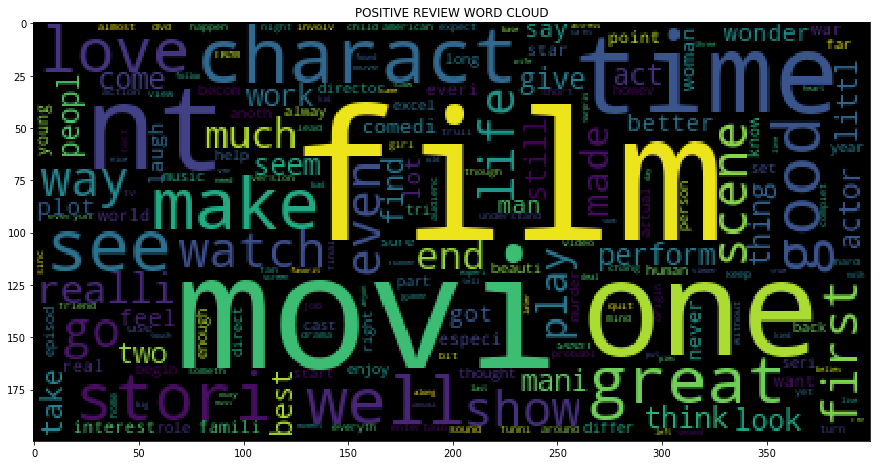

In [52]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.title("POSITIVE REVIEW WORD CLOUD")
plt.imshow(positive_full_review_wc)
plt.show()

In [53]:
neg_rev_list = []
for review in neg_full.Review:
    neg_rev_list.append(text_process(review))

neg_rev_list

['well watch ton movi one realli suck big time sure sick tire low budget ploy make vampir movi use martial art teacher turn actor type movi also tire guy know form fight techniqu abl fight way somewhat bore movi forc watch one main reason lead actress quit pretti ha ha well hope help bit time want give brain rest watch well hope one day type movi releas hey low budget actor go movi also contain mani bloop leav find add quit bit fun watch also bit perfectionist bother cheer',
 'fell asleep couch pm last night watch larri sander usual directivo last night woke inves banker west coast fascin see hbo shock poor movi  serious shock shock write commentari imdb realli realli bad write bore direct edit simpli freshman film school ye shot video mind shot video digit video look like soap opera clip skateboard video film  feel horror want describ poor direct honestli cant rememb anyth shot block stupid ye chose word stupid  unconvent dare bold bore stupid know peopl review review say well give ex

In [54]:
len(neg_rev_list)

250

In [55]:
neg_full_review = " ".join(neg_rev_list)

len(neg_full_review)

176376

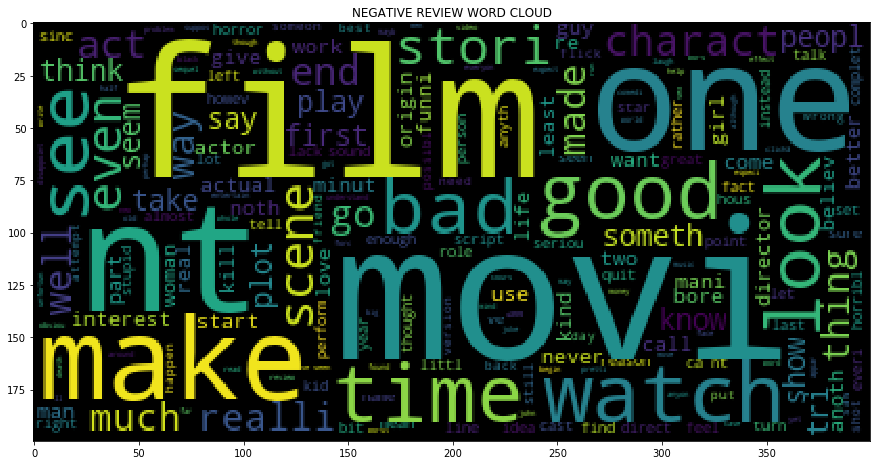

In [56]:
neg_full_review_wc = WordCloud().generate(neg_full_review)

plt.figure(figsize=(15,10))
plt.title("NEGATIVE REVIEW WORD CLOUD")
plt.imshow(neg_full_review_wc)
plt.show()

----------------
----------------
# Generating Histogram of POS and NEG words

In [57]:
cv = CountVectorizer()
pos_hist_reviwes_bkp = pd.DataFrame(cv.fit_transform(pos_rev_list).toarray(), columns=cv.get_feature_names())
pos_hist_reviwes_bkp.head()


,abandon,abdomen,abductor,abil,abl,abolish,aboutagirli,abrupt,absenc,absent,...,zentropa,zero,zhao,zhigang,zhou,zhu,zizek,zoe,zombi,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [58]:
pos_hist_reviwes_bkp.head()

,abandon,abdomen,abductor,abil,abl,abolish,aboutagirli,abrupt,absenc,absent,...,zentropa,zero,zhao,zhigang,zhou,zhu,zizek,zoe,zombi,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [59]:
a = dict()
for i in pos_hist_reviwes_bkp.columns:
    a[i]= pos_hist_reviwes_bkp[i].sum()
pos_data = pd.DataFrame(list(a.items()),columns=['word','freq'])
pos_data.head()

,word,freq
0,abandon,1
1,abdomen,1
2,abductor,1
3,abil,6
4,abl,20


In [60]:
pos_data.sort_values('freq',inplace=True)
pos_data.head()


,word,freq
0,abandon,1
3153,mcclure,1
3154,mcconaughey,1
3156,meadow,1
3161,measur,1


[62, 63, 64, 65, 66, 67, 67, 68, 70, 71, 71, 71, 72, 73, 74, 75, 76, 76, 78, 79, 82, 86, 87, 87, 90, 96, 98, 99, 103, 104, 105, 111, 111, 116, 116, 121, 126, 127, 131, 133, 138, 146, 160, 172, 174, 183, 266, 268, 403, 507]


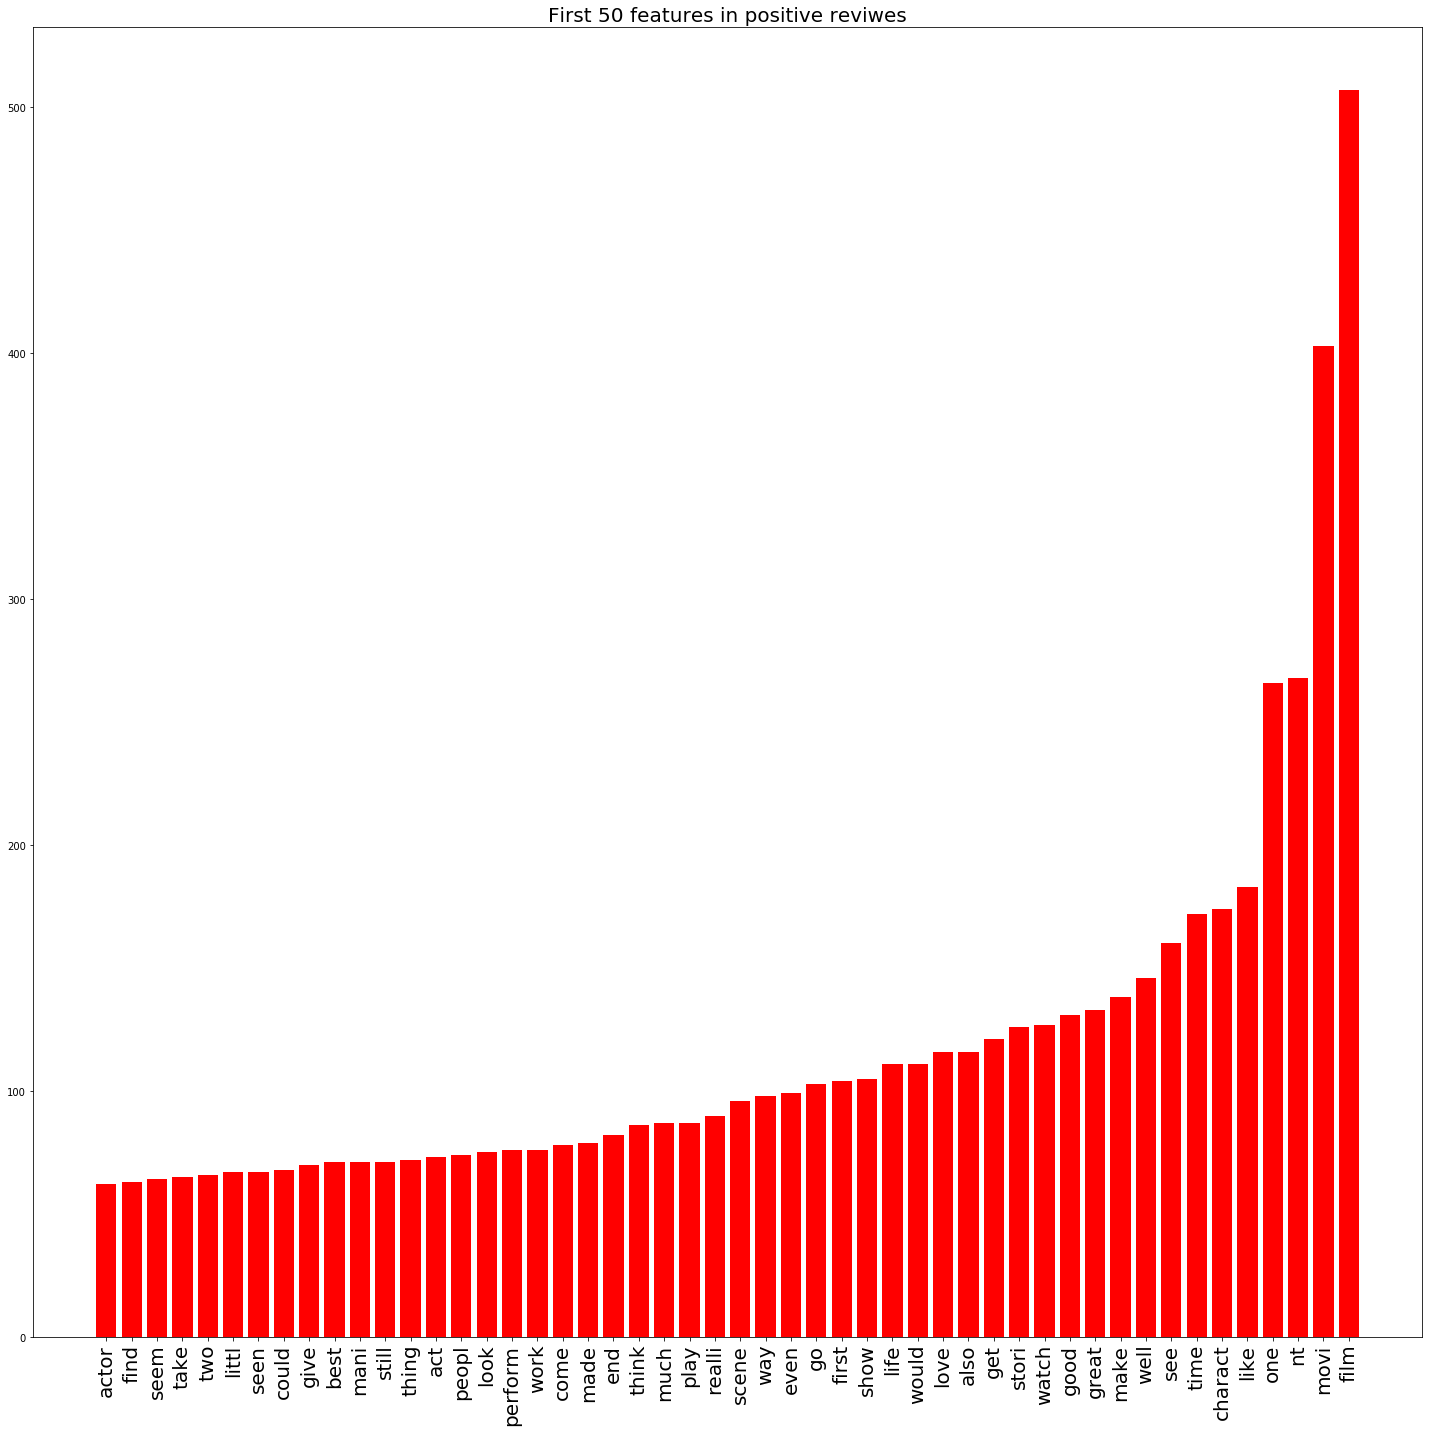

In [61]:
word = list(pos_data[-50:].word)
frequency = list(pos_data[-50:].freq)
print(frequency)
indices = np.arange(len(pos_data[-50:]))
plt.figure(figsize=(20,20))
plt.title("First 50 features in positive reviwes",fontsize = 20)
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical',fontsize=20)
plt.tight_layout()
plt.show()
#random 50 words

In [62]:
cv = CountVectorizer()
neg_hist_reviwes_bkp = pd.DataFrame(cv.fit_transform(neg_rev_list).toarray(), columns=cv.get_feature_names())
neg_hist_reviwes_bkp.head()


,aaron,abandon,abdomen,abduct,abe,abil,abl,abli,aboard,abomin,...,zelweg,zemeki,zenith,zero,zeta,zhivago,zinger,zombi,zoom,ã¼bermenschlich
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
a = dict()
for i in neg_hist_reviwes_bkp.columns:
    a[i]= neg_hist_reviwes_bkp[i].sum()
neg_data = pd.DataFrame(list(a.items()),columns=['word','freq'])
neg_data.head()

,word,freq
0,aaron,5
1,abandon,1
2,abdomen,1
3,abduct,1
4,abe,1


In [64]:
neg_data.sort_values('freq',inplace=True)
neg_data.head()

,word,freq
5865,ã¼bermenschlich,1
2139,geraã,1
2140,gere,1
4210,regress,1
2142,germani,1


[61, 61, 61, 61, 61, 63, 63, 64, 66, 68, 68, 68, 68, 73, 76, 77, 78, 79, 80, 80, 81, 82, 82, 84, 91, 95, 95, 97, 103, 104, 104, 115, 121, 124, 127, 127, 130, 138, 139, 140, 141, 143, 147, 151, 153, 225, 286, 389, 444, 506]


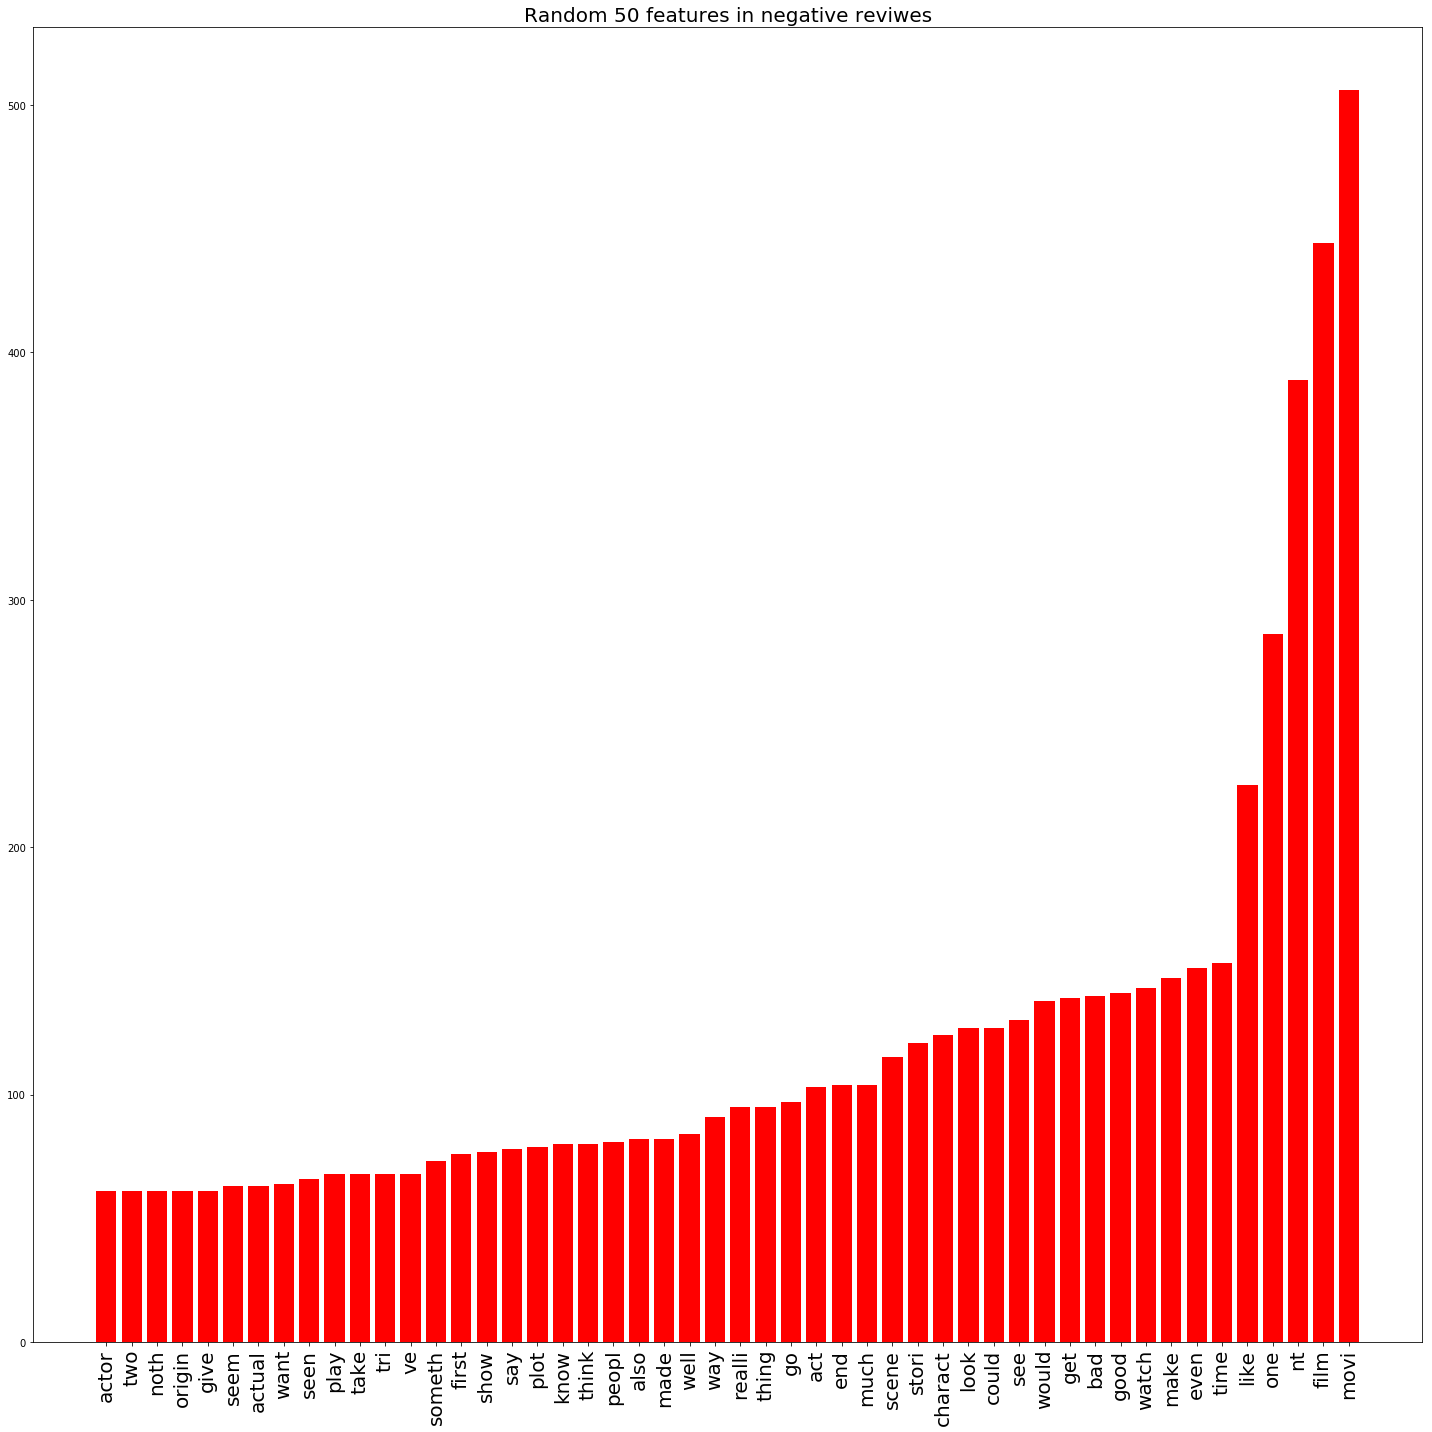

In [65]:
word = list(neg_data[-50:].word)
frequency = list(neg_data[-50:].freq)
print(frequency)
indices = np.arange(len(neg_data[-50:]))
plt.figure(figsize=(20,20))
plt.title("Random 50 features in negative reviwes",fontsize = 20)
plt.bar(indices, frequency, color='r')
plt.xticks(indices, word, rotation='vertical',fontsize=20)
plt.tight_layout()
plt.show()

------------------
# Creating Word cloud of POS and NEG words after cleansing and feature selection

In [66]:
cv = CountVectorizer()
pos_hist_reviwes_bkp = pd.DataFrame(cv.fit_transform(pos_rev_list).toarray(), columns=cv.get_feature_names())
pos_hist_reviwes_bkp.head()


,abandon,abdomen,abductor,abil,abl,abolish,aboutagirli,abrupt,absenc,absent,...,zentropa,zero,zhao,zhigang,zhou,zhu,zizek,zoe,zombi,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [67]:
a = dict()
for i in pos_hist_reviwes_bkp.columns:
    a[i]= pos_hist_reviwes_bkp[i].sum()

In [68]:
pos_data = pd.DataFrame(a,index=[0])
pos_data.head()

,abandon,abdomen,abductor,abil,abl,abolish,aboutagirli,abrupt,absenc,absent,...,zentropa,zero,zhao,zhigang,zhou,zhu,zizek,zoe,zombi,zone
0,1,1,1,6,20,1,1,1,2,1,...,1,1,1,1,1,1,3,2,3,1


In [69]:
features_to_drop = []

for word in pos_data.columns:
    #print(int(pos_data[word]))
    if int(pos_data[word]) < 50:
        features_to_drop.append(word)
len(features_to_drop)

pos_data.drop(features_to_drop,axis=1,inplace=True)
pos_data

,act,actor,also,best,better,cast,charact,come,comedi,could,...,ve,want,watch,way,well,woman,wonder,work,would,year
0,73,62,116,71,54,51,174,78,50,68,...,56,55,127,98,146,50,55,76,111,58


In [70]:
pos_data_list = list(pos_data.columns)
pos_data_feature_clean = " ".join(pos_data_list)
pos_data_feature_clean_wc = WordCloud().generate(pos_data_feature_clean)

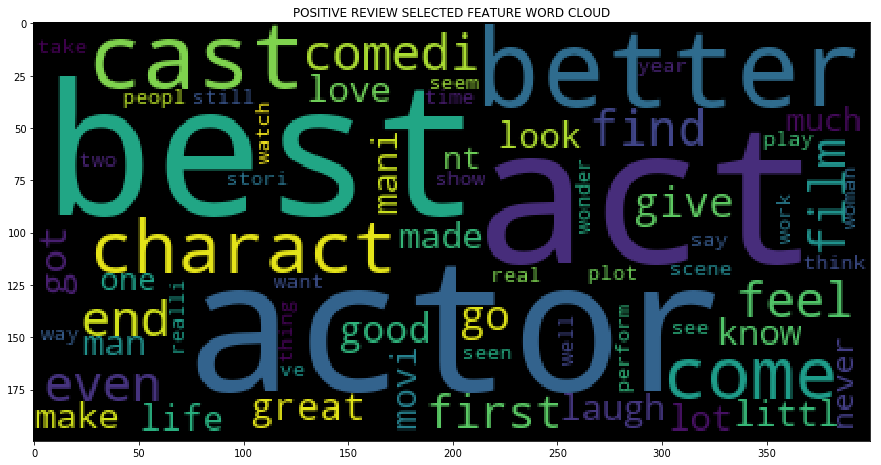

In [71]:
plt.figure(figsize=(15,10))
plt.title("POSITIVE REVIEW SELECTED FEATURE WORD CLOUD")
plt.imshow(pos_data_feature_clean_wc)
plt.show()

In [72]:
cv = CountVectorizer()
neg_hist_reviwes_bkp = pd.DataFrame(cv.fit_transform(neg_rev_list).toarray(), columns=cv.get_feature_names())
neg_hist_reviwes_bkp.head()

,aaron,abandon,abdomen,abduct,abe,abil,abl,abli,aboard,abomin,...,zelweg,zemeki,zenith,zero,zeta,zhivago,zinger,zombi,zoom,ã¼bermenschlich
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [73]:
a = dict()
for i in neg_hist_reviwes_bkp.columns:
    a[i]= neg_hist_reviwes_bkp[i].sum()

In [74]:
neg_data = pd.DataFrame(a,index=[0])
neg_data.head()

,aaron,abandon,abdomen,abduct,abe,abil,abl,abli,aboard,abomin,...,zelweg,zemeki,zenith,zero,zeta,zhivago,zinger,zombi,zoom,ã¼bermenschlich
0,5,1,1,1,1,3,19,1,1,1,...,1,1,1,2,2,1,1,14,2,1


In [75]:
features_to_drop = []

for word in neg_data.columns:
    if int(neg_data[word]) < 50:
        features_to_drop.append(word)
len(features_to_drop)

neg_data.drop(features_to_drop,axis=1,inplace=True)
neg_data

,act,actor,actual,also,bad,better,charact,come,could,effect,...,time,tri,two,ve,want,watch,way,well,woman,would
0,103,61,63,82,140,59,124,56,127,50,...,153,68,61,68,64,143,91,84,58,138


In [76]:
neg_data_list = list(neg_data.columns)
neg_data_feature_clean = " ".join(neg_data_list)
neg_data_feature_clean_wc = WordCloud().generate(neg_data_feature_clean)

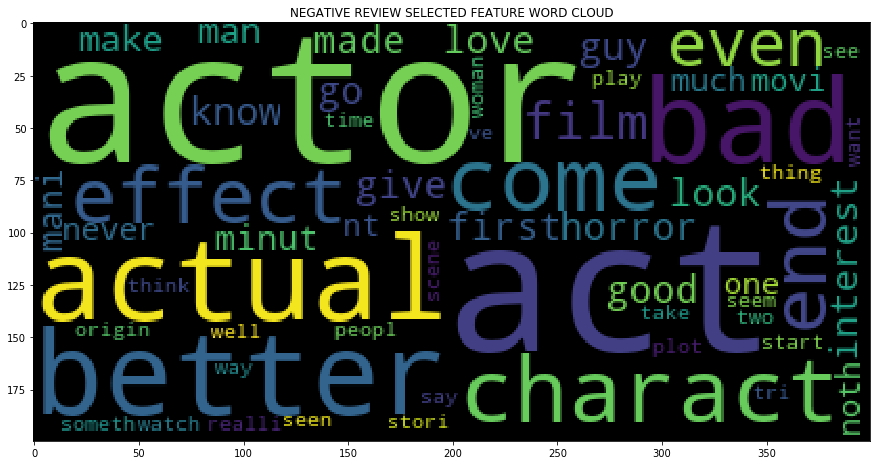

In [77]:
plt.figure(figsize=(15,10))
plt.title("NEGATIVE REVIEW SELECTED FEATURE WORD CLOUD")
plt.imshow(neg_data_feature_clean_wc)
plt.show()

-----------------------
# Phase 4
> In this phase we are going to perform Feature Selection:


------------------------------------
# Phase 5 Model Building :
> In this phase we are going to perform following activities
 1. Supervised Learning: Build a sentiment analysis model to predict positive and negative classes 
 2. Unsupervised Learning: Build a clustering model consisting of 2 clusters based on positive and negative reviews 

*******************************************************************************************************************

# Description of steps
## We are going to model supervised and unsupervised models stage by stage
1. first we will see performance on uncleaned data
2. then we will perform data cleaning and see performance over it
3. lastly we will see performance with n-grams

In [199]:
imdb_test = imdb_review[imdb_review['Type']=="test"]
imdb_train= imdb_review[imdb_review['Type']=="train"]
print(imdb_test.Label.unique())
print(imdb_train.Label.unique())

['neg' 'pos']
['neg' 'pos' 'unsup']


## Seprating unsupervised data from train data 

In [200]:
imdb_train_unsup = imdb_train[imdb_train['Label']=="unsup"]
print(imdb_train_unsup.shape)
imdb_train_unsup.head()

(50000, 4)


,Type,Review,Label,File
50000,train,"I admit, the great majority of films released ...",unsup,0_0.txt
50001,train,"Take a low budget, inexperienced actors doubli...",unsup,10000_0.txt
50002,train,"Everybody has seen 'Back To The Future,' right...",unsup,10001_0.txt
50003,train,Doris Day was an icon of beauty in singing and...,unsup,10002_0.txt
50004,train,"After a series of silly, fun-loving movies, 19...",unsup,10003_0.txt


In [201]:
imdb_train= imdb_train[imdb_train.Label != "unsup"]
imdb_train.head()

,Type,Review,Label,File
25000,train,Story of a man who has unnatural feelings for ...,neg,0_3.txt
25001,train,Airport '77 starts as a brand new luxury 747 p...,neg,10000_4.txt
25002,train,This film lacked something I couldn't put my f...,neg,10001_4.txt
25003,train,"Sorry everyone,,, I know this is supposed to b...",neg,10002_1.txt
25004,train,When I was little my parents took me along to ...,neg,10003_1.txt


In [202]:
print("test size              "+str(imdb_test.shape)+"              Labels "+str(imdb_test.Label.unique()))
print("unsupervised train size"+str(imdb_train_unsup.shape)+"              Labels "+str(imdb_train_unsup.Label.unique()))
print("train size             "+str(imdb_train.shape)+"              Labels "+str(imdb_train.Label.unique()))

test size              (25000, 4)              Labels ['neg' 'pos']
unsupervised train size(50000, 4)              Labels ['unsup']
train size             (25000, 4)              Labels ['neg' 'pos']


-----------------------------------------------------

# Supervised learning models

## we will model
1. Logistic regression
2. Decision Tree
3. Random Forest 
4. Naive Bayes
5. SVM

## Using raw data without preprocessing it

In [203]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

In [204]:
def linearregressor(X_baseline, target_train):
    X_train, X_val, y_train, y_val = train_test_split(X_baseline, target_train, train_size = 0.75)
    for c in [0.01, 0.05, 0.25, 0.5, 1]:
        lr = LogisticRegression(C=c)
        lr.fit(X_train, y_train)
        print ("Accuracy for C=%s: %s"% (c, accuracy_score(y_val, lr.predict(X_val))))

In [205]:
def decisiontree(X_baseline, target_train):
    X_train, X_val, y_train, y_val = train_test_split(X_baseline, target_train, train_size = 0.75)
    max_depths = np.linspace(1, 32, 32, endpoint=True)
    
    for depth in max_depths:
        dt = DecisionTreeClassifier(max_depth=depth)
        dt.fit(X_train, y_train)
        print ("Accuracy for depth=%s: %s"% (depth, accuracy_score(y_val, dt.predict(X_val))))
    

In [206]:
def randomforest(X_baseline, target_train):
    X_train, X_val, y_train, y_val = train_test_split(X_baseline, target_train, train_size = 0.75)
    for estimator in range(30,50):
        rf = RandomForestClassifier(n_estimators=estimator)
        rf.fit(X_train, y_train)
        print ("Accuracy for estimator=%s: %s"% (estimator, accuracy_score(y_val, rf.predict(X_val))))
    

In [207]:
def naivebayes(X_baseline, target_train):
    X_train, X_val, y_train, y_val = train_test_split(X_baseline, target_train, train_size = 0.75)
    nb = MultinomialNB()
    nb.fit(X_train, y_train)
    print ("Accuracy = %s"% (accuracy_score(y_val,nb.predict(X_val))))
    

In [208]:
def supportvector(X_baseline, target_train):
    
    X_train, X_val, y_train, y_val = train_test_split(X_baseline, target_train, train_size = 0.75)
    for c in [0.01, 0.05, 0.25, 0.5, 1]:
        svm = LinearSVC(C=c)
        svm.fit(X_train, y_train)
        print ("Accuracy for C=%s: %s"% (c, accuracy_score(y_val, svm.predict(X_val))))

In [209]:
reviews_train = list(imdb_train.Review)
reviews_test = list(imdb_test.Review)
target_train = imdb_train['Label']
target_test = imdb_test['Label']

In [210]:
baseline_vectorizer = CountVectorizer(binary=True)
baseline_vectorizer.fit(reviews_train)
X_baseline = baseline_vectorizer.transform(reviews_train)
X_test_baseline = baseline_vectorizer.transform(reviews_test)

In [211]:
linearregressor(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.87392
Accuracy for C=0.05: 0.88176
Accuracy for C=0.25: 0.88592
Accuracy for C=0.5: 0.88128
Accuracy for C=1: 0.87856


In [212]:
# Best performance came at c = .25
final_model = LogisticRegression(C=.25)
final_model.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, final_model.predict(X_test_baseline))) 

Final Accuracy: 0.87716


In [213]:
decisiontree(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for depth=1.0: 0.62144
Accuracy for depth=2.0: 0.6576
Accuracy for depth=3.0: 0.67808
Accuracy for depth=4.0: 0.69472
Accuracy for depth=5.0: 0.69584
Accuracy for depth=6.0: 0.69824
Accuracy for depth=7.0: 0.71216
Accuracy for depth=8.0: 0.72448
Accuracy for depth=9.0: 0.72816
Accuracy for depth=10.0: 0.73616
Accuracy for depth=11.0: 0.73984
Accuracy for depth=12.0: 0.73536
Accuracy for depth=13.0: 0.73488
Accuracy for depth=14.0: 0.73264
Accuracy for depth=15.0: 0.73536
Accuracy for depth=16.0: 0.73392
Accuracy for depth=17.0: 0.73408
Accuracy for depth=18.0: 0.73296
Accuracy for depth=19.0: 0.73984
Accuracy for depth=20.0: 0.74112
Accuracy for depth=21.0: 0.73456
Accuracy for depth=22.0: 0.73552
Accuracy for depth=23.0: 0.73104
Accuracy for depth=24.0: 0.7328
Accuracy for depth=25.0: 0.73408
Accuracy for depth=26.0: 0.73536
Accuracy for depth=27.0: 0.7328
Accuracy for depth=28.0: 0.73648
Accuracy for depth=29.0: 0.7336
Accuracy for depth=30.0: 0.73296
Accuracy for depth=31.0

In [214]:
# best performace came at depth = 20
dt = DecisionTreeClassifier(max_depth=20)
dt.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, dt.predict(X_test_baseline))) 

Final Accuracy: 0.73296


In [215]:
randomforest(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for estimator=30: 0.81024
Accuracy for estimator=31: 0.8032
Accuracy for estimator=32: 0.81184
Accuracy for estimator=33: 0.80464
Accuracy for estimator=34: 0.80192
Accuracy for estimator=35: 0.80928
Accuracy for estimator=36: 0.81152
Accuracy for estimator=37: 0.81296
Accuracy for estimator=38: 0.8168
Accuracy for estimator=39: 0.81232
Accuracy for estimator=40: 0.81936
Accuracy for estimator=41: 0.81888
Accuracy for estimator=42: 0.81664
Accuracy for estimator=43: 0.82608
Accuracy for estimator=44: 0.82592
Accuracy for estimator=45: 0.82512
Accuracy for estimator=46: 0.81904
Accuracy for estimator=47: 0.82384
Accuracy for estimator=48: 0.82528
Accuracy for estimator=49: 0.8256


In [216]:
# best performance is noticed at estimator 43
rf = RandomForestClassifier(n_estimators=43)
rf.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, rf.predict(X_test_baseline)))

Final Accuracy: 0.82284


In [217]:
naivebayes(X_baseline, target_train)

Accuracy = 0.86


c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [218]:
supportvector(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.8808
Accuracy for C=0.05: 0.87168
Accuracy for C=0.25: 0.85968
Accuracy for C=0.5: 0.8544
Accuracy for C=1: 0.84912


In [219]:
# best performance is noted at c = .01
final_svm = LinearSVC(C=0.01)
final_svm.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, final_svm.predict(X_test_baseline)))

Final Accuracy: 0.87964


## Performaing data clean on train and test data 

In [234]:
rindex =  np.array(sample(range(len(imdb_train)), 3000)) 
# we are taking only 1000 rows randomly exclude this to check with full data
imdb_train_small= copy.deepcopy(imdb_train.iloc[rindex])

#imdb_train_small= copy.deepcopy(imdb_train) # taking full dataset instead of 1000 rows

In [235]:
imdb_train_small.shape
target_train = imdb_train_small['Label']

In [236]:
review_list_train = []
for review in imdb_train_small.Review: #remove 200
    review_list_train.append(text_process(review))
#review_list_train

In [237]:
reviews_train = review_list_train
#reviews_train

In [238]:
rindex =  np.array(sample(range(len(imdb_test)), 3000)) 
# we are taking only 1000 rows randomly exclude this to check with full data
imdb_test_small= copy.deepcopy(imdb_test.iloc[rindex])
#imdb_test_small= copy.deepcopy(imdb_test)
target_test = imdb_test_small['Label']

In [239]:
review_list_test = []
for review in imdb_test_small.Review:  #remove 200
    review_list_test.append(text_process(review))
#review_list_test

In [240]:
reviews_test = review_list_test
#reviews_test

In [241]:
reviews_train[:10],reviews_test[:10] , target_train[:10],target_test[:10]

(['mean spirit right degrad adapt classic child s tale lack charm forefath lack talent ever mike myer asham horribl perform clear rip jim carrey give act togeth annoy would want beat crap abl jump right film set ugli cinematographi poor seen lot bad film year take cake doubt one wors film ever made',
  'blackadd probabl blackadd seri peopl least heard basic principl second fourth one noth revolutionari still great fieri duke wellington fat foolish dr johnson writer first dictionari england make seri one reckon still hilari one liner deliv seri bring humour lesser known era histor accur enjoy episod blackadd s third outing famou well known lot rowan atkinson s role butler stupid princ funni effect done one hugh lauri best seri good',
  'class reunion under comedi gem s class lizzi borden high return year reunion among usual stereotyp hunk babe fat guy  nerd etc former student bumpi night one classmat walter baloer class wimp subject comedi prank rest class graduat night sinc mental home

## making supervised learning models

In [242]:
baseline_vectorizer = CountVectorizer(binary=True)
baseline_vectorizer.fit(reviews_train)
X_baseline = baseline_vectorizer.transform(reviews_train)
X_test_baseline = baseline_vectorizer.transform(reviews_test)

In [243]:
linearregressor(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.8266666666666667
Accuracy for C=0.05: 0.8346666666666667
Accuracy for C=0.25: 0.828
Accuracy for C=0.5: 0.8253333333333334
Accuracy for C=1: 0.8186666666666667


In [244]:
# Best performance came at c = .05
final_model = LogisticRegression(C=.05)
final_model.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, final_model.predict(X_test_baseline))) 

Final Accuracy: 0.8426666666666667


In [245]:
decisiontree(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for depth=1.0: 0.5773333333333334
Accuracy for depth=2.0: 0.6053333333333333
Accuracy for depth=3.0: 0.648
Accuracy for depth=4.0: 0.6586666666666666
Accuracy for depth=5.0: 0.652
Accuracy for depth=6.0: 0.648
Accuracy for depth=7.0: 0.6413333333333333
Accuracy for depth=8.0: 0.656
Accuracy for depth=9.0: 0.6626666666666666
Accuracy for depth=10.0: 0.668
Accuracy for depth=11.0: 0.6613333333333333
Accuracy for depth=12.0: 0.6613333333333333
Accuracy for depth=13.0: 0.6653333333333333
Accuracy for depth=14.0: 0.668
Accuracy for depth=15.0: 0.6653333333333333
Accuracy for depth=16.0: 0.6613333333333333
Accuracy for depth=17.0: 0.68
Accuracy for depth=18.0: 0.6826666666666666
Accuracy for depth=19.0: 0.6653333333333333
Accuracy for depth=20.0: 0.6853333333333333
Accuracy for depth=21.0: 0.68
Accuracy for depth=22.0: 0.6613333333333333
Accuracy for depth=23.0: 0.6693333333333333
Accuracy for depth=24.0: 0.6733333333333333
Accuracy for depth=25.0: 0.6613333333333333
Accuracy for de

In [246]:
# best performace came at depth = 20
dt = DecisionTreeClassifier(max_depth=20)
dt.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, dt.predict(X_test_baseline))) 

Final Accuracy: 0.7073333333333334


In [247]:
randomforest(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for estimator=30: 0.7626666666666667
Accuracy for estimator=31: 0.7986666666666666
Accuracy for estimator=32: 0.7853333333333333
Accuracy for estimator=33: 0.8
Accuracy for estimator=34: 0.7506666666666667
Accuracy for estimator=35: 0.7613333333333333
Accuracy for estimator=36: 0.78
Accuracy for estimator=37: 0.796
Accuracy for estimator=38: 0.784
Accuracy for estimator=39: 0.7773333333333333
Accuracy for estimator=40: 0.8013333333333333
Accuracy for estimator=41: 0.772
Accuracy for estimator=42: 0.7893333333333333
Accuracy for estimator=43: 0.8053333333333333
Accuracy for estimator=44: 0.7946666666666666
Accuracy for estimator=45: 0.7706666666666667
Accuracy for estimator=46: 0.7866666666666666
Accuracy for estimator=47: 0.7973333333333333
Accuracy for estimator=48: 0.8013333333333333
Accuracy for estimator=49: 0.776


In [249]:
# best performance is noticed at estimator 48
rf = RandomForestClassifier(n_estimators=48)
rf.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, rf.predict(X_test_baseline)))

Final Accuracy: 0.7933333333333333


In [250]:
naivebayes(X_baseline, target_train)

Accuracy = 0.852


c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [251]:
supportvector(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.8386666666666667
Accuracy for C=0.05: 0.8333333333333334
Accuracy for C=0.25: 0.8266666666666667
Accuracy for C=0.5: 0.8226666666666667
Accuracy for C=1: 0.82


In [252]:
# best performance is noted at c = .01
final_svm = LinearSVC(C=0.01)
final_svm.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, final_svm.predict(X_test_baseline)))

Final Accuracy: 0.8416666666666667


## using n- grams to check models performance

In [256]:
rindex =  np.array(sample(range(len(imdb_train)), 3000)) 
# we are taking only 1000 rows randomly exclude this to check with full data
imdb_train_small= copy.deepcopy(imdb_train.iloc[rindex])
#imdb_train_small= copy.deepcopy(imdb_train)

In [257]:
imdb_train_small.shape
target_train = imdb_train_small['Label']

In [258]:
review_list_train = []
for review in imdb_train_small.Review: #remove 200
    review_list_train.append(text_process(review))
#review_list_train

In [259]:
reviews_train = review_list_train
#reviews_train

In [260]:
rindex =  np.array(sample(range(len(imdb_test)), 3000)) 
# we are taking only 1000 rows randomly exclude this to check with full data
imdb_test_small= copy.deepcopy(imdb_test.iloc[rindex])
#imdb_test_small= copy.deepcopy(imdb_test)
target_test = imdb_test_small['Label']

In [261]:
review_list_test = []
for review in imdb_test_small.Review:  #remove 200
    review_list_test.append(text_process(review))
#review_list_test

In [262]:
reviews_test = review_list_test
#reviews_test

In [263]:
reviews_train[:10],reviews_test[:10] , target_train[:10],target_test[:10]

(['parker stone transplant paci explet ridden humour anim masterpiec featur length live action film gener good result much film trey matt run amok new toy box plot simplic two averag guy invent new sport blend driveway basketbal basebal score becom nation craze along way encount numer sport movi clich send along bit popular cultur come sight run like stretch south park episod usual machin gun dialogu toilet humour homili heart film weak associ team gave u airplan nake gun seri influenc clearli seen heavi use lame sight gag presenc glossi rather two dimension yasmin bleeth role usual given priscilla presley robert vaughn littl better play corpor btard parti piec ever sinc bullitt ernest borgnin overact one must admit s perfect role lunat team owner nt notic yet parker stone seem comfort rock star wannab comic manifest promin given soundtrack everyth creat usual give good select includ obligatori track ultra non pc vehicl dvda special mention must go dian bachar deserv sort award endur d

In [264]:
baseline_vectorizer = CountVectorizer(binary=True,ngram_range=(1, 2))
baseline_vectorizer.fit(reviews_train)
X_baseline = baseline_vectorizer.transform(reviews_train)
X_test_baseline = baseline_vectorizer.transform(reviews_test)

In [265]:
linearregressor(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.8426666666666667
Accuracy for C=0.05: 0.8386666666666667
Accuracy for C=0.25: 0.8426666666666667
Accuracy for C=0.5: 0.8426666666666667
Accuracy for C=1: 0.8426666666666667


In [267]:
# Best performance came at c = 1.0
final_model = LogisticRegression(C=1.0)
final_model.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, final_model.predict(X_test_baseline))) 

Final Accuracy: 0.8586666666666667


In [268]:
decisiontree(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for depth=1.0: 0.6093333333333333
Accuracy for depth=2.0: 0.6266666666666667
Accuracy for depth=3.0: 0.6653333333333333
Accuracy for depth=4.0: 0.6586666666666666
Accuracy for depth=5.0: 0.656
Accuracy for depth=6.0: 0.6626666666666666
Accuracy for depth=7.0: 0.6773333333333333
Accuracy for depth=8.0: 0.668
Accuracy for depth=9.0: 0.6706666666666666
Accuracy for depth=10.0: 0.6733333333333333
Accuracy for depth=11.0: 0.672
Accuracy for depth=12.0: 0.672
Accuracy for depth=13.0: 0.668
Accuracy for depth=14.0: 0.664
Accuracy for depth=15.0: 0.6626666666666666
Accuracy for depth=16.0: 0.664
Accuracy for depth=17.0: 0.66
Accuracy for depth=18.0: 0.6573333333333333
Accuracy for depth=19.0: 0.6626666666666666
Accuracy for depth=20.0: 0.664
Accuracy for depth=21.0: 0.672
Accuracy for depth=22.0: 0.6626666666666666
Accuracy for depth=23.0: 0.6626666666666666
Accuracy for depth=24.0: 0.6733333333333333
Accuracy for depth=25.0: 0.664
Accuracy for depth=26.0: 0.64
Accuracy for depth=27.0

In [269]:
# best performace came at depth = 7
dt = DecisionTreeClassifier(max_depth=7)
dt.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, dt.predict(X_test_baseline))) 

Final Accuracy: 0.683


In [270]:
randomforest(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for estimator=30: 0.7946666666666666
Accuracy for estimator=31: 0.7893333333333333
Accuracy for estimator=32: 0.8106666666666666
Accuracy for estimator=33: 0.7946666666666666
Accuracy for estimator=34: 0.7986666666666666
Accuracy for estimator=35: 0.8
Accuracy for estimator=36: 0.7986666666666666
Accuracy for estimator=37: 0.816
Accuracy for estimator=38: 0.7893333333333333
Accuracy for estimator=39: 0.8293333333333334
Accuracy for estimator=40: 0.8013333333333333
Accuracy for estimator=41: 0.816
Accuracy for estimator=42: 0.816
Accuracy for estimator=43: 0.8306666666666667
Accuracy for estimator=44: 0.8053333333333333
Accuracy for estimator=45: 0.8013333333333333
Accuracy for estimator=46: 0.82
Accuracy for estimator=47: 0.8026666666666666
Accuracy for estimator=48: 0.8146666666666667
Accuracy for estimator=49: 0.8066666666666666


In [271]:
# best performance is noticed at estimator 39
rf = RandomForestClassifier(n_estimators=39)
rf.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, rf.predict(X_test_baseline)))

Final Accuracy: 0.8073333333333333


In [272]:
naivebayes(X_baseline, target_train)

Accuracy = 0.8613333333333333


c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [273]:
supportvector(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.8586666666666667
Accuracy for C=0.05: 0.8533333333333334
Accuracy for C=0.25: 0.848
Accuracy for C=0.5: 0.848
Accuracy for C=1: 0.848


In [274]:
# best performance is noted at c = .01
final_svm = LinearSVC(C=0.05)
final_svm.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, final_svm.predict(X_test_baseline)))

Final Accuracy: 0.8596666666666667


## rechecking for stop_words = ['in', 'of', 'at', 'a', 'the'] and cleaning it  

In [275]:
rindex =  np.array(sample(range(len(imdb_train)), 3000)) 
# we are taking only 1000 rows randomly exclude this to check with full data
imdb_train_small= copy.deepcopy(imdb_train.iloc[rindex])
#imdb_train_small= copy.deepcopy(imdb_train)

In [276]:
imdb_train_small.shape
target_train = imdb_train_small['Label']

In [277]:
review_list_train = []
for review in imdb_train_small.Review: #remove 200
    review_list_train.append(text_process(review))
#review_list_train

In [278]:
reviews_train = review_list_train
#reviews_train

In [279]:
rindex =  np.array(sample(range(len(imdb_test)), 3000)) 
# we are taking only 1000 rows randomly exclude this to check with full data
imdb_test_small= copy.deepcopy(imdb_test.iloc[rindex])
#imdb_test_small= copy.deepcopy(imdb_test)
target_test = imdb_test_small['Label']

In [280]:
review_list_test = []
for review in imdb_test_small.Review:  #remove 200
    review_list_test.append(text_process(review))
#review_list_test

In [281]:
reviews_test = review_list_test
#reviews_test

In [282]:
reviews_train[:10],reviews_test[:10] , target_train[:10],target_test[:10]

(['saw trailer film look great went bought mistak act shambl special effect could call look like someth would nt place school play charact stupid film cring minut screen unfortun often stori forget warn nt wast money film one worst thing ever seen reason like film watch troll probabl enjoy well',
  'best movi ve seen sinc white best romant comedi ve seen sinc hairdress s husband emot beauti masterwork kenneth branagh helena bonham carter tragedi movi nt gotten recognit',
  'first heard earth pretti excit m pretti big fan chri rock especi hilari dogma film prove disappoint chri rock s perform nearli good past perform movi badli direct whole first chri rock play entir movi standup comedi routin obvious work fine scene s suppos standup rest movi nt even s talk one charact seem think s tri make room peopl laugh funni moment mostli come standup scene wonder decid make charact comedian rest cast re pretti much give rock someon talk none stand also movi poorli direct movi basic one joke plot 

In [283]:
stop_words = ['in', 'of', 'at', 'a', 'the']

baseline_vectorizer = CountVectorizer(binary=True,ngram_range=(1, 3),stop_words=stop_words)
baseline_vectorizer.fit(reviews_train)
X_baseline = baseline_vectorizer.transform(reviews_train)
X_test_baseline = baseline_vectorizer.transform(reviews_test)

In [284]:
linearregressor(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.848
Accuracy for C=0.05: 0.848
Accuracy for C=0.25: 0.8533333333333334
Accuracy for C=0.5: 0.8546666666666667
Accuracy for C=1: 0.8533333333333334


In [285]:
# Best performance came at c = .05
final_model = LogisticRegression(C=.05)
final_model.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, final_model.predict(X_test_baseline))) 

Final Accuracy: 0.8463333333333334


In [286]:
decisiontree(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for depth=1.0: 0.5973333333333334
Accuracy for depth=2.0: 0.6386666666666667
Accuracy for depth=3.0: 0.6546666666666666
Accuracy for depth=4.0: 0.6506666666666666
Accuracy for depth=5.0: 0.6466666666666666
Accuracy for depth=6.0: 0.664
Accuracy for depth=7.0: 0.6893333333333334
Accuracy for depth=8.0: 0.6973333333333334
Accuracy for depth=9.0: 0.6893333333333334
Accuracy for depth=10.0: 0.688
Accuracy for depth=11.0: 0.6853333333333333
Accuracy for depth=12.0: 0.7066666666666667
Accuracy for depth=13.0: 0.696
Accuracy for depth=14.0: 0.7026666666666667
Accuracy for depth=15.0: 0.708
Accuracy for depth=16.0: 0.7
Accuracy for depth=17.0: 0.6946666666666667
Accuracy for depth=18.0: 0.6946666666666667
Accuracy for depth=19.0: 0.6946666666666667
Accuracy for depth=20.0: 0.708
Accuracy for depth=21.0: 0.704
Accuracy for depth=22.0: 0.7106666666666667
Accuracy for depth=23.0: 0.7026666666666667
Accuracy for depth=24.0: 0.708
Accuracy for depth=25.0: 0.704
Accuracy for depth=26.0: 0.6

In [287]:
# best performace came at depth = 22
dt = DecisionTreeClassifier(max_depth=22)
dt.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, dt.predict(X_test_baseline))) 

Final Accuracy: 0.7173333333333334


In [288]:
randomforest(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for estimator=30: 0.7746666666666666
Accuracy for estimator=31: 0.776
Accuracy for estimator=32: 0.7813333333333333
Accuracy for estimator=33: 0.7853333333333333
Accuracy for estimator=34: 0.7893333333333333
Accuracy for estimator=35: 0.784
Accuracy for estimator=36: 0.78
Accuracy for estimator=37: 0.772
Accuracy for estimator=38: 0.784
Accuracy for estimator=39: 0.7946666666666666
Accuracy for estimator=40: 0.772
Accuracy for estimator=41: 0.784
Accuracy for estimator=42: 0.7693333333333333
Accuracy for estimator=43: 0.7786666666666666
Accuracy for estimator=44: 0.776
Accuracy for estimator=45: 0.796
Accuracy for estimator=46: 0.7853333333333333
Accuracy for estimator=47: 0.7586666666666667
Accuracy for estimator=48: 0.7893333333333333
Accuracy for estimator=49: 0.7813333333333333


In [289]:
# best performance is noticed at estimator 39
rf = RandomForestClassifier(n_estimators=39)
rf.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, rf.predict(X_test_baseline)))

Final Accuracy: 0.796


In [290]:
naivebayes(X_baseline, target_train)

Accuracy = 0.8226666666666667


c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [291]:
supportvector(X_baseline, target_train)

c:\users\punitha.hs\appdata\local\programs\python\python36\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Accuracy for C=0.01: 0.8426666666666667
Accuracy for C=0.05: 0.8386666666666667
Accuracy for C=0.25: 0.8386666666666667
Accuracy for C=0.5: 0.8386666666666667
Accuracy for C=1: 0.84


In [292]:
# best performance is noted at c = .01
final_svm = LinearSVC(C=0.01)
final_svm.fit(X_baseline, target_train)
print ("Final Accuracy: %s" % accuracy_score(target_test, final_svm.predict(X_test_baseline)))

Final Accuracy: 0.85


-----------------------------------------------------

# Unsupervised learning models

## Clustering Algorithms

1. KMeans

## performing on uncleaned data

In [293]:
reviews_train = list(imdb_train.Review)
reviews_test = list(imdb_test.Review)
target_train = imdb_train['Label']
target_test = imdb_test['Label']

In [294]:
review = []

review = reviews_train+reviews_test

In [295]:
reviews_train[:10],reviews_test[:10] , target_train[:10],target_test[:10]
#type(reviews_train),type(reviews_test) 

(["Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.",
  "Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public as a museum, also on board is Stevens daughter Julie (Kathleen Quinlan) & her so

In [296]:
baseline_vectorizer = CountVectorizer(binary=True)
X_baseline = baseline_vectorizer.fit_transform(review)

In [297]:
baseline_vectorizer.vocabulary_

{'story': 87256,
 'of': 64489,
 'man': 55937,
 'who': 100362,
 'has': 41233,
 'unnatural': 96215,
 'feelings': 33084,
 'for': 34883,
 'pig': 68996,
 'starts': 86570,
 'out': 65618,
 'with': 100980,
 'opening': 65035,
 'scene': 79682,
 'that': 91218,
 'is': 47339,
 'terrific': 90994,
 'example': 31390,
 'absurd': 1997,
 'comedy': 18853,
 'formal': 35060,
 'orchestra': 65217,
 'audience': 6950,
 'turned': 94428,
 'into': 46912,
 'an': 4492,
 'insane': 46300,
 'violent': 98352,
 'mob': 59779,
 'by': 13982,
 'the': 91242,
 'crazy': 21369,
 'chantings': 16205,
 'it': 47481,
 'singers': 83109,
 'unfortunately': 95834,
 'stays': 86660,
 'whole': 100370,
 'time': 92046,
 'no': 63266,
 'general': 37182,
 'narrative': 62020,
 'eventually': 31195,
 'making': 55707,
 'just': 49060,
 'too': 92621,
 'off': 64497,
 'putting': 72733,
 'even': 31174,
 'those': 91629,
 'from': 35861,
 'era': 30575,
 'should': 82388,
 'be': 8907,
 'cryptic': 21964,
 'dialogue': 25149,
 'would': 101498,
 'make': 55687,
 '

# KMeans

In [298]:
data = []
num_clusters = 2
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
kmeans = kmeans_model.fit(X_baseline)

In [299]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = baseline_vectorizer.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :50]:
        print(' %s' % terms[ind])

Cluster 0:
 the
 and
 of
 to
 this
 is
 it
 in
 that
 but
 for
 with
 movie
 was
 as
 on
 not
 film
 have
 you
 br
 one
 be
 are
 all
 at
 an
 like
 so
 from
 by
 if
 who
 just
 out
 they
 there
 about
 good
 his
 or
 has
 what
 can
 he
 some
 my
 very
 time
 more
Cluster 1:
 the
 of
 to
 in
 and
 is
 it
 that
 this
 for
 with
 but
 as
 on
 br
 not
 be
 was
 are
 one
 have
 at
 all
 an
 by
 from
 film
 you
 who
 so
 his
 he
 they
 like
 there
 out
 or
 movie
 has
 about
 what
 just
 if
 some
 when
 more
 can
 up
 even
 no


## cleaninig data and performing clustering

In [300]:
rindex =  np.array(sample(range(len(imdb_train)), 3000)) 
# we are taking only 1000 rows randomly exclude this to check with full data
imdb_train_small= copy.deepcopy(imdb_train.iloc[rindex])
#imdb_train_small= copy.deepcopy(imdb_train)

In [301]:
imdb_train_small.shape
target_train = imdb_train_small['Label']

In [302]:
review_list_train = []
for review in imdb_train_small.Review: #remove 200
    review_list_train.append(text_process(review))
#review_list_train

In [303]:
reviews_train = review_list_train
#reviews_train

In [304]:
rindex =  np.array(sample(range(len(imdb_test)), 3000)) 
# we are taking only 1000 rows randomly exclude this to check with full data
imdb_test_small= copy.deepcopy(imdb_test.iloc[rindex])
#imdb_test_small= copy.deepcopy(imdb_test)
target_test = imdb_test_small['Label']

In [305]:
review_list_test = []
for review in imdb_test_small.Review:  #remove 200
    review_list_test.append(text_process(review))
#review_list_test

In [306]:
reviews_test = review_list_test
#reviews_test

In [307]:
review = []

review = reviews_train+reviews_test

In [308]:
baseline_vectorizer = CountVectorizer(binary=True)
X_baseline = baseline_vectorizer.fit_transform(review)

In [309]:
baseline_vectorizer.vocabulary_

{'surpris': 24508,
 'saw': 21816,
 'film': 8870,
 'heard': 11198,
 'best': 2329,
 'ever': 8241,
 'novel': 17568,
 'disappoint': 6752,
 'true': 25960,
 'jane': 12877,
 'austen': 1504,
 'fan': 8549,
 'rate': 20390,
 'adapt': 209,
 'mysteri': 16939,
 'eye': 8442,
 'scriptwrit': 22065,
 'decid': 6172,
 'stick': 23961,
 'bit': 2502,
 'ridicul': 21061,
 'humour': 11912,
 'embarrass': 7825,
 'time': 25409,
 'also': 658,
 'ruin': 21459,
 'feel': 8708,
 'period': 18824,
 'cast': 3935,
 'gwyneth': 10789,
 'paltrow': 18398,
 'make': 15199,
 'rather': 20393,
 'shallow': 22426,
 'heroin': 11385,
 'hot': 11797,
 'american': 736,
 'star': 23814,
 'would': 28168,
 'question': 20146,
 'role': 21261,
 'toni': 25567,
 'collett': 4884,
 'miscast': 16279,
 'poor': 19391,
 'ewan': 8282,
 'mcgregor': 15728,
 'made': 15095,
 'look': 14745,
 'laughabl': 14166,
 'realli': 20466,
 'could': 5424,
 'say': 21826,
 'good': 10303,
 'thing': 25244,
 'seem': 22177,
 'among': 766,
 'nt': 17590,
 'want': 27494,
 'advic':

In [310]:
data = []
num_clusters = 2
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
kmeans = kmeans_model.fit(X_baseline)

In [311]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = baseline_vectorizer.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind])

Cluster 0:
 stood
 away
 display
 earli
 buddi
 subplot
 budget
 regard
 end
 fullscreen
 around
 start
 invitingli
 spare
 get
 imaginari
 herd
 toward
 much
 begin
Cluster 1:
 movi
 film
 nt
 one
 like
 time
 good
 make
 see
 watch
 get
 would
 even
 charact
 go
 stori
 well
 realli
 much
 act


## using n-gram

In [312]:
stop_words = ['in', 'of', 'at', 'a', 'the','nt']
baseline_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words)
X_baseline = baseline_vectorizer.fit_transform(review)

In [313]:
baseline_vectorizer.vocabulary_

{'surpris': 1006051,
 'saw': 879136,
 'film': 357746,
 'heard': 463416,
 'best': 95512,
 'ever': 316376,
 'novel': 712145,
 'disappoint': 259058,
 'true': 1069325,
 'jane': 522751,
 'austen': 67468,
 'fan': 341958,
 'rate': 822619,
 'adapt': 15721,
 'mysteri': 689113,
 'eye': 333430,
 'scriptwrit': 894589,
 'decid': 236617,
 'stick': 978598,
 'bit': 103714,
 'ridicul': 858272,
 'humour': 490414,
 'embarrass': 291565,
 'time': 1044574,
 'also': 30864,
 'ruin': 870276,
 'feel': 350529,
 'period': 762699,
 'cast': 146107,
 'gwyneth': 451049,
 'paltrow': 745281,
 'make': 613762,
 'rather': 823405,
 'shallow': 920064,
 'heroin': 469324,
 'hot': 483943,
 'american': 38098,
 'star': 971518,
 'would': 1156700,
 'question': 815341,
 'role': 864468,
 'toni': 1054568,
 'collett': 181876,
 'miscast': 653080,
 'poor': 785919,
 'ewan': 322367,
 'mcgregor': 635404,
 'made': 608312,
 'look': 593657,
 'laughabl': 557441,
 'realli': 831481,
 'could': 206998,
 'say': 880325,
 'good': 430198,
 'thing': 10

In [314]:
data = []
num_clusters = 2
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
kmeans = kmeans_model.fit(X_baseline)

In [315]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = baseline_vectorizer.get_feature_names()
for i in range(2):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :50]:
        print(' %s' % terms[ind])

Cluster 0:
 de pari
 love human movi
 member actual
 member actual interest
 ii anim
 ii anim movi
 spend
 love show
 love show around
 cant
 movi cant
 movi cant find
 point
 versions
 versions huge
 versions huge fan
 made
 stuck
 music
 junk noth
 junk noth creator
 kind director edit
 kind director
 junk
 cant find
 must read
 must read book
 villain realli
 villain realli bad
 mention love
 mention love frollo
 read
 cant find anyth
 hope watch good
 member
 someth
 hope watch
 mention mother
 show around
 summer watch movi
 summer watch
 much
 ii
 movi soldier
 mention phoebu
 mention phoebu mention
 clock write word
 notr dame
 notr
 mother
Cluster 1:
 movi
 film
 one
 like
 time
 good
 make
 see
 watch
 get
 would
 even
 charact
 go
 stori
 well
 realli
 much
 act
 look
 end
 could
 scene
 great
 think
 way
 first
 also
 made
 peopl
 love
 thing
 bad
 know
 say
 play
 show
 seen
 plot
 come
 seem
 life
 want
 work
 take
 mani
 actor
 never
 tri
 year


## Acording to initial findings it turns out using n-grams and kmeans we found cluster 0 has more negative words 

--------------------------------
# Extra Activities
> In this Phase we are going to perform following activities
1. Divide the data into 4 clusters to enable finding more classes. Analyse each cluster and try to find the correct label for the new cluster. Repeat clustering until 4 new labels can be found, other than the original labels (positive and negative) 
4. Active Learning: Cluster the training dataset and try and find the genre. Manually annotate the cluster and then try to find the labels in the new testing dataset.


## performing on uncleaned data

In [316]:
reviews_train = list(imdb_train.Review)
reviews_test = list(imdb_test.Review)
target_train = imdb_train['Label']
target_test = imdb_test['Label']

In [317]:
review = []

review = reviews_train+reviews_test

In [318]:
reviews_train[:10],reviews_test[:10] , target_train[:10],target_test[:10]
#type(reviews_train),type(reviews_test) 

(["Story of a man who has unnatural feelings for a pig. Starts out with a opening scene that is a terrific example of absurd comedy. A formal orchestra audience is turned into an insane, violent mob by the crazy chantings of it's singers. Unfortunately it stays absurd the WHOLE time with no general narrative eventually making it just too off putting. Even those from the era should be turned off. The cryptic dialogue would make Shakespeare seem easy to a third grader. On a technical level it's better than you might think with some good cinematography by future great Vilmos Zsigmond. Future stars Sally Kirkland and Frederic Forrest can be seen briefly.",
  "Airport '77 starts as a brand new luxury 747 plane is loaded up with valuable paintings & such belonging to rich businessman Philip Stevens (James Stewart) who is flying them & a bunch of VIP's to his estate in preparation of it being opened to the public as a museum, also on board is Stevens daughter Julie (Kathleen Quinlan) & her so

In [319]:
baseline_vectorizer = CountVectorizer(binary=True)
X_baseline = baseline_vectorizer.fit_transform(review)

In [320]:
baseline_vectorizer.vocabulary_

{'story': 87256,
 'of': 64489,
 'man': 55937,
 'who': 100362,
 'has': 41233,
 'unnatural': 96215,
 'feelings': 33084,
 'for': 34883,
 'pig': 68996,
 'starts': 86570,
 'out': 65618,
 'with': 100980,
 'opening': 65035,
 'scene': 79682,
 'that': 91218,
 'is': 47339,
 'terrific': 90994,
 'example': 31390,
 'absurd': 1997,
 'comedy': 18853,
 'formal': 35060,
 'orchestra': 65217,
 'audience': 6950,
 'turned': 94428,
 'into': 46912,
 'an': 4492,
 'insane': 46300,
 'violent': 98352,
 'mob': 59779,
 'by': 13982,
 'the': 91242,
 'crazy': 21369,
 'chantings': 16205,
 'it': 47481,
 'singers': 83109,
 'unfortunately': 95834,
 'stays': 86660,
 'whole': 100370,
 'time': 92046,
 'no': 63266,
 'general': 37182,
 'narrative': 62020,
 'eventually': 31195,
 'making': 55707,
 'just': 49060,
 'too': 92621,
 'off': 64497,
 'putting': 72733,
 'even': 31174,
 'those': 91629,
 'from': 35861,
 'era': 30575,
 'should': 82388,
 'be': 8907,
 'cryptic': 21964,
 'dialogue': 25149,
 'would': 101498,
 'make': 55687,
 '

# KMeans

In [321]:
data = []
num_clusters = 4
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
kmeans = kmeans_model.fit(X_baseline)

In [322]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = baseline_vectorizer.get_feature_names()
for i in range(4):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :50]:
        print(' %s' % terms[ind])

Cluster 0:
 which
 br
 are
 to
 other
 can
 so
 when
 no
 end
 scenes
 people
 has
 in
 character
 and
 characters
 like
 scene
 even
 we
 this
 of
 they
 these
 about
 there
 an
 main
 two
 music
 their
 with
 film
 the
 that
 lot
 well
 thing
 what
 much
 on
 really
 all
 he
 is
 was
 his
 but
 it
Cluster 1:
 the
 and
 of
 to
 this
 is
 it
 in
 that
 but
 for
 with
 movie
 was
 as
 on
 not
 film
 have
 you
 br
 one
 be
 are
 all
 at
 an
 like
 so
 from
 by
 if
 who
 just
 out
 they
 there
 about
 good
 his
 or
 has
 what
 can
 he
 some
 my
 very
 time
 more
Cluster 2:
 the
 of
 to
 in
 and
 is
 it
 that
 this
 for
 with
 but
 as
 on
 br
 not
 be
 was
 are
 one
 have
 at
 all
 an
 by
 from
 film
 you
 who
 so
 his
 he
 they
 like
 there
 out
 or
 movie
 has
 about
 what
 just
 if
 some
 when
 more
 can
 up
 even
 no
Cluster 3:
 cast
 oscar
 more
 hilarious
 so
 named
 to
 unger
 expanded
 like
 wife
 obsessive
 depressed
 films
 friend
 vividly
 madison
 consistent
 divorced
 art
 lau

## cleaninig data and performing clustering

In [323]:
rindex =  np.array(sample(range(len(imdb_train)), 3000)) 
# we are taking only 1000 rows randomly exclude this to check with full data
imdb_train_small= copy.deepcopy(imdb_train.iloc[rindex])
#imdb_train_small= copy.deepcopy(imdb_train)

In [324]:
imdb_train_small.shape
target_train = imdb_train_small['Label']

In [325]:
review_list_train = []
for review in imdb_train_small.Review: #remove 200
    review_list_train.append(text_process(review))
#review_list_train

In [326]:
reviews_train = review_list_train

In [327]:
rindex =  np.array(sample(range(len(imdb_test)), 3000)) 
# we are taking only 1000 rows randomly exclude this to check with full data
imdb_test_small= copy.deepcopy(imdb_test.iloc[rindex])
#imdb_test_small= copy.deepcopy(imdb_test)
target_test = imdb_test_small['Label']

In [328]:
review_list_test = []
for review in imdb_test_small.Review:  #remove 200
    review_list_test.append(text_process(review))
#review_list_test

In [329]:
reviews_test = review_list_test

In [330]:
review = []

review = reviews_train+reviews_test

In [331]:
baseline_vectorizer = CountVectorizer(binary=True)
X_baseline = baseline_vectorizer.fit_transform(review)

In [332]:
baseline_vectorizer.vocabulary_

{'tear': 25000,
 'kali': 13384,
 'origin': 18046,
 'yet': 28355,
 'flaw': 9044,
 'horror': 11802,
 'film': 8865,
 'delf': 6273,
 'do': 6945,
 'cult': 5741,
 'group': 10598,
 'india': 12369,
 'compris': 4997,
 'german': 9936,
 'psychologist': 19938,
 'learn': 14311,
 'control': 5208,
 'will': 27926,
 'bodi': 2701,
 'point': 19324,
 'caus': 3955,
 'other': 18104,
 'heal': 11185,
 'radic': 20241,
 'techniqu': 25019,
 'trigger': 25942,
 'nightmarish': 17383,
 'hallucin': 10877,
 'physic': 19025,
 'pain': 18346,
 'tortur': 25687,
 'releas': 20720,
 'pent': 18775,
 'demon': 6336,
 'insid': 12544,
 'shown': 22723,
 'seri': 22340,
 'vignett': 27227,
 'taylor': 24974,
 'eriksson': 8056,
 'mention': 15979,
 'first': 8945,
 'segment': 22228,
 'somewhat': 23420,
 'slower': 23147,
 'rest': 20914,
 'serf': 22335,
 'fine': 8897,
 'set': 22367,
 'premis': 19630,
 'play': 19219,
 'like': 14581,
 'mindf': 16238,
 'ck': 4547,
 'key': 13605,
 'stapl': 23874,
 'thrown': 25385,
 'mix': 16402,
 'full': 9551,

In [333]:
data = []
num_clusters = 4
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
kmeans = kmeans_model.fit(X_baseline)

In [334]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = baseline_vectorizer.get_feature_names()
for i in range(4):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :20]:
        print(' %s' % terms[ind])

Cluster 0:
 nt
 movi
 one
 like
 film
 make
 get
 time
 good
 see
 watch
 even
 would
 go
 realli
 charact
 look
 much
 well
 think
Cluster 1:
 alien
 seen
 track
 past
 hate
 would
 mention
 unifi
 dialog
 bit
 tv
 recommend
 thing
 littl
 ordinari
 ocean
 front
 never
 object
 robot
Cluster 2:
 movi
 film
 one
 nt
 like
 watch
 time
 good
 see
 stori
 make
 charact
 would
 get
 act
 great
 even
 well
 realli
 love
Cluster 3:
 one
 nt
 film
 like
 time
 make
 movi
 get
 go
 good
 see
 charact
 even
 would
 way
 much
 also
 well
 end
 stori


## using n-gram

In [355]:
stop_words = ['in', 'of', 'at', 'a', 'the','nt']
baseline_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3), stop_words=stop_words)
X_baseline = baseline_vectorizer.fit_transform(review)

In [356]:
baseline_vectorizer.vocabulary_

{'tear': 1018604,
 'kali': 532394,
 'origin': 735412,
 'yet': 1166005,
 'flaw': 379777,
 'horror': 481465,
 'film': 356737,
 'delf': 239484,
 'do': 263445,
 'cult': 221079,
 'group': 444133,
 'india': 503539,
 'compris': 192619,
 'german': 410540,
 'psychologist': 809232,
 'learn': 561119,
 'control': 200559,
 'will': 1136462,
 'bodi': 110498,
 'point': 782396,
 'caus': 148557,
 'other': 737553,
 'heal': 461537,
 'radic': 818901,
 'techniqu': 1019210,
 'trigger': 1066028,
 'nightmarish': 705530,
 'hallucin': 451886,
 'physic': 767408,
 'pain': 743909,
 'tortur': 1055207,
 'releas': 842463,
 'pent': 755575,
 'demon': 241096,
 'insid': 507885,
 'shown': 930907,
 'seri': 912290,
 'vignett': 1102740,
 'taylor': 1017536,
 'eriksson': 306300,
 'mention': 641767,
 'first': 375225,
 'segment': 907498,
 'somewhat': 954921,
 'slower': 945737,
 'rest': 851437,
 'serf': 912127,
 'fine': 373382,
 'set': 915003,
 'premis': 794555,
 'play': 774407,
 'like': 573795,
 'mindf': 650135,
 'ck': 171703,
 '

In [357]:
data = []
num_clusters = 4
kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=1)
kmeans = kmeans_model.fit(X_baseline)

In [358]:
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = baseline_vectorizer.get_feature_names()
for i in range(4):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :50]:
        print(' %s' % terms[ind])

Cluster 0:
 go
 give rest
 gorgeou invent camera
 gorgeou invent
 music
 excit possibl
 movi pain
 excit possibl sound
 flawless three
 flawless three big
 lead
 think
 charact seem run
 place talk thing
 place talk
 fill
 probabl excit
 movi pain static
 impress
 also cast femal
 big bit
 someth make
 femal lead
 one els
 wonder
 two without
 big bit impress
 two without music
 also cast
 charact seem
 femal lead nd
 go reward
 go reward small
 place
 incred
 probabl excit possibl
 impress sure
 impress sure second
 direct
 pain
 whirlwind
 whirlwind decad
 end absolut
 whirlwind decad plenti
 end absolut incred
 bella
 earli
 wow
 charact
 gorgeou
Cluster 1:
 movi
 film
 one
 like
 time
 make
 good
 see
 get
 watch
 would
 even
 charact
 go
 stori
 realli
 well
 much
 look
 act
 end
 could
 way
 scene
 also
 think
 great
 peopl
 first
 made
 thing
 bad
 love
 know
 say
 play
 show
 seen
 never
 life
 come
 actor
 seem
 work
 mani
 plot
 want
 take
 tri
 littl
Cluster 2:
 burst back
 

# from above analysis it is found that
1. cluster0 has words like  beast,thrill,visual etc so it may be of genre cartoon or animation 
2. cluster1 has words like  look,love,like  so it may be of genre roamnce 
3. cluster2 has words like  job,time,surprise,crime,drama etc so it may be of genre thrill
4. cluster3 has words like  documantry, eisenstein, etc  so it may be of genre documantry 